# Logistic Regression

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('/Users/omojumiller/mycode/tools')

import numpy as np
import pandas as pd
import scipy.stats as st
from tools import plot_features_by_target


# Use CPickle if available
try:
   import cPickle as pickle
except:
   import pickle

# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("whitegrid")  

# Configure for presentation
np.set_printoptions(threshold=50, linewidth=50)
import matplotlib as mpl
mpl.rc('font', size=16)

from IPython.display import display

In [186]:
import re

def get_col_types(row):
    """Get the number of numeric types and the rest"""
    num_of_numerics = 0

    i = 0
    num_index = []
    str_index = []
    for dp in row:
        if re.findall("[-+]?\d+[\.]?\d*[eE]?[-+]?\d*", dp):
            num_of_numerics += 1
            num_index.append(i)
            i += 1
        else:
            str_index.append(i)
            i += 1
                

    num_of_str = len(row) - num_of_numerics
    
    return dict(num_of_numerics=num_of_numerics, num_index=num_index,
         num_of_str=num_of_str, str_index=str_index)

In [302]:
import csv

# Load a CSV file
def load_csv(fname):
    """
    Read in a csv file
    
    Attributes:
    fname: string (filename)
    """
    num_lines = sum(1 for line in open(fname, 'rU'))

    with open(fname, 'rU') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        header = csv_reader.next()
        row = csv_reader.next()
        my_dtypes = get_col_types(row)

        X = numpy.zeros(shape=(num_lines, my_dtypes['num_of_numerics']))
        X_str = []

        # fill first row
        index = 0
        tmp = []
        for i in  my_dtypes['num_index']:
            tmp.append(float(row[i]))   
        X[index] = tmp

        tmp = []
        for i in  my_dtypes['str_index']:
            tmp.append(row[i])  
        X_str.append(tmp)

        # update the index
        index += 1

        # fill the rest of the table
        for row in csv_reader:
            tmp = []
            for i in  my_dtypes['num_index']:
                tmp.append(float(row[i]))   
            X[index] = tmp

            tmp = []
            for i in  my_dtypes['str_index']:
                tmp.append(row[i])  
            X_str.append(tmp)

            index += 1
        
    return (X[:-1], X_str[:-1])

In [303]:
fname = 'data/actors.csv'

In [304]:
X, X_str = load_csv(fname)

In [305]:
X

array([[ 4871.7,    41. ,   118.8,   936.7],
       [ 4772.8,    69. ,    69.2,   623.4],
       [ 4468.3,    61. ,    73.3,   534.9],
       ..., 
       [ 2462.6,    35. ,    70.4,   336. ],
       [ 2457.8,    23. ,   106.9,   623.4],
       [ 2416.5,    25. ,    96.7,   448.1]])

In [224]:
df = pd.read_csv('data/actors.csv')

In [225]:
df.columns = ['Actor', 'TotalGross', 'NumberOfMovies', 'AveragePerMovie', 'Num1Movie', 'Gross']
df.head()

,Actor,TotalGross,NumberOfMovies,AveragePerMovie,Num1Movie,Gross
0,Harrison Ford,4871.7,41,118.8,Star Wars: The Force Awakens,936.7
1,Samuel L. Jackson,4772.8,69,69.2,The Avengers,623.4
2,Morgan Freeman,4468.3,61,73.3,The Dark Knight,534.9
3,Tom Hanks,4340.8,44,98.7,Toy Story 3,415.0
4,"Robert Downey, Jr.",3947.3,53,74.5,The Avengers,623.4


In [226]:
x_vars = ['NumberOfMovies', 'AveragePerMovie', 'Gross']
y_vars=['TotalGross']

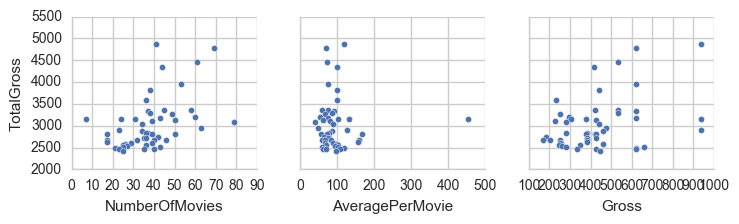

In [227]:
plot_features_by_target(df, x_vars, y_vars)

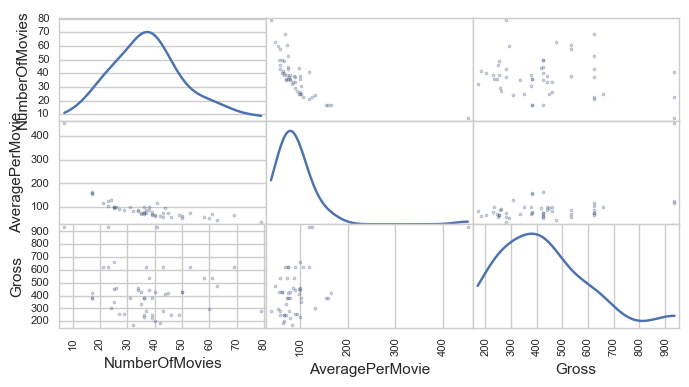

In [230]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(df[x_vars], alpha = 0.3, figsize = (8,4), diagonal = 'kde');

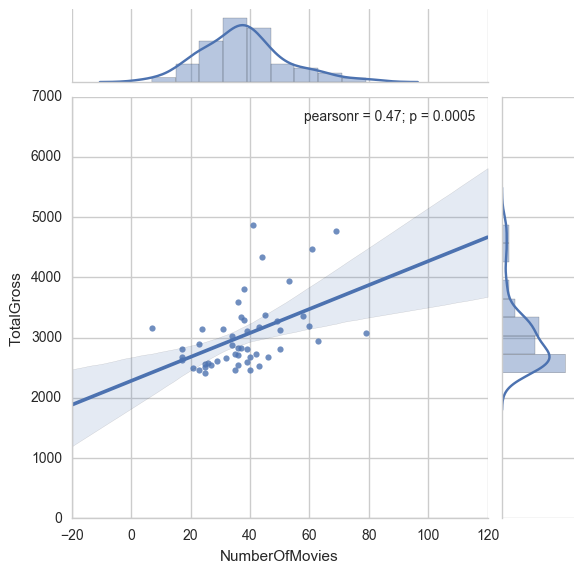

In [59]:
sns.jointplot(x='NumberOfMovies', y='TotalGross', data=df, kind='reg');

In [278]:
class LinearRegression():
    """Linear model for doing regression.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=False):
        self.w = None
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.gradient_descent = gradient_descent    # Opt. method. If False => Least squares

    def fit(self, X, y):
        # Insert constant ones as first column (for bias weights)
        X = np.insert(X, 0, 1, axis=1)
        # Get weights by gradient descent opt.
        if self.gradient_descent:
            n_features = np.shape(X)[1]
            # Initial weights randomly [0, 1]
            self.w = np.random.random((n_features, ))
            # Do gradient descent for n_iterations
            for _ in range(self.n_iterations):
                # Gradient of squared loss w.r.t the weights
                w_gradient = X.T.dot(X.dot(self.w) - y)
                print(w_gradient)
                # Move against the gradient to minimize loss
                self.w -= self.learning_rate * w_gradient
        # Get weights by least squares (by pseudoinverse)
        else:
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_inv.dot(X.T).dot(y)
            
        return(self.w)

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

In [306]:
num_train = int(len(X) * .75)

In [335]:
X_train, y_train = X[:,[1]][:num_train], X[:,[0]][:num_train]
X_test, y_test = X[:,[1]][num_train:], X[:,[0]][num_train:]
XX = X[:,[0, 1]]

In [336]:
clf = LinearRegression()
reg_weights = clf.fit(X_train, y_train)

In [337]:
y_preds = clf.predict(X_test)
error = y_test -  y_preds

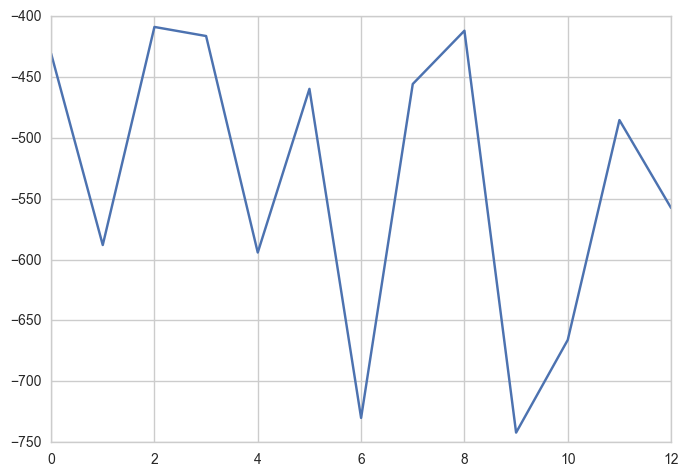

In [338]:

pyplt.plot(error);

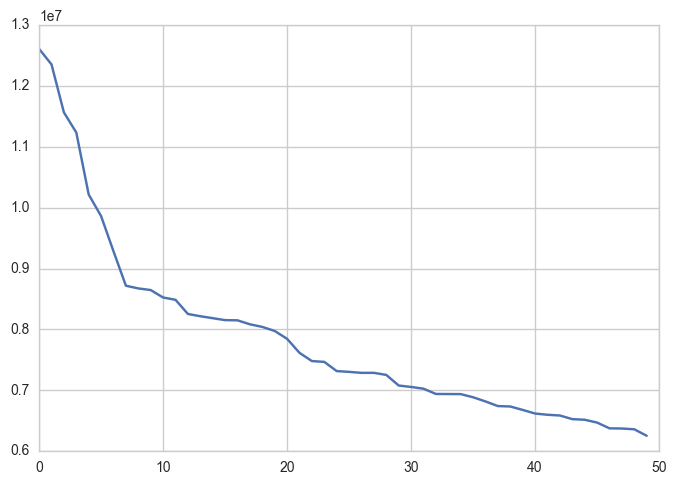

In [344]:
reg_line = []
for i in range(len(XX)): 
    reg_line.append(XX[i].T.dot(reg_weights))
    
pyplt.plot(reg_line);